In [1]:
import cv2
import itertools
import copy
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"


In [2]:
mi.set_variant('cuda_ad_rgb')

In [3]:
from mitsuba import ScalarTransform4f as T

In [22]:
# scene_both = mi.load_file("Scene_Data/cbox_lego_both.xml")
# view_both = mi.render(scene_both, spp=1)
# mi.Bitmap(view_both).write('both.exr')
# both = cv2.imread('both.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# plt.axis("off")
# plt.imshow(cv2.cvtColor(both** (1.0/2.2), cv2.COLOR_BGR2RGB))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


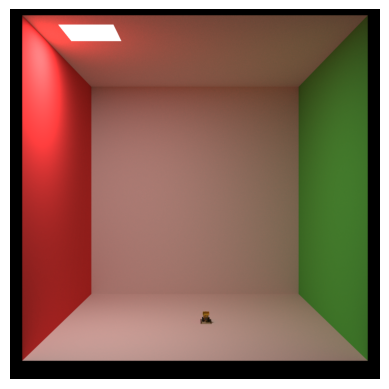

In [19]:
# scene_low = mi.load_file("Scene_Data/cbox_left.xml")
# view_low = mi.render(scene_low, spp=1)
# plt.axis("off")
# plt.imshow(view_low** (1.0/2.2))

In [ ]:
# xml_file_path = 'Scene_Data/cbox_lego_both.xml'

# # Parse the XML file
# tree = ET.parse(xml_file_path)
# root = tree.getroot()

# # Function to set radiance of specific lights to 0
# def set_radiance_to_zero(root, light_ids_to_zero):
#     for shape in root.findall('.//shape'):
#         if shape.get('id') in light_ids_to_zero:
#             for emitter in shape.findall('.//emitter'):
#                 for rgb in emitter.findall('.//rgb'):
#                     if rgb.get('name') == 'radiance':
#                         rgb.set('value', '0')
#     return root

# # Extract light IDs
# light_ids = ["light_0", "light_1", "light_2", "light_3"]

# # Generate combinations of lights to turn off (1 at a time, 2 at a time, 3 at a time)
# combinations = []
# for i in range(1, 4):
#     combinations.extend(itertools.combinations(light_ids, i))

# # Ensure only 15 scenarios
# combinations = combinations[:15]

In [4]:
def load_sensor(r, theta, phi, pts):
    # Apply two rotations to convert from spherical coordinates to world 3D coordinates.
    origin = pts + T.rotate([0, 0, 1], phi).rotate([0, 1, 0], theta) @ mi.ScalarPoint3f([0, 0, r])

    return mi.load_dict({
        'type': 'perspective',
        'fov': 39.37,
        'to_world': T.look_at(
            origin=origin,
            target=pts,
            up=[0, 1, 0]
        ),
        'sampler': {
            'type': 'independent',
            'sample_count': 16
        },
        'film': {
            'type': 'hdrfilm',
            'width': 1024,
            'height': 1024,
            'rfilter': {
                'type': 'tent',
            },
            'pixel_format': 'rgb',
        },
    })

In [ ]:
radius = 5
phis = [30*(j+1) for j in range(6)]
# phis = [0]
thetas = [25*(i+1) for i in range(8)]
# thetas = [90]
pts = [[1.2,0.5,1]]

sensors = []
for pt in pts:
    for phi in phis:
        for theta in thetas:
            sensors.append(load_sensor(radius,theta,phi,pt))
sensor_count = len(sensors)

In [5]:
radius = 11
phis = [30*(j+1) for j in range(6)]
# phis = [0]
thetas = [25*(i+1) for i in range(6)]
# thetas = [90]
pts = [[1.2,1.0,1]]
sensors = []
for pt in pts:
    for phi in phis:
        for theta in thetas:
            sensors.append(load_sensor(radius, theta, phi, pt))
sensor_count = len(sensors)

In [ ]:
radius = 9
phis = [30*(j+1) for j in range(6)]
# phis = [0]
thetas = [25*(i+1) for i in range(7)]
# thetas = [90]
pts = [[1.2,-1,1]]

for pt in pts:
    for phi in phis:
        for theta in thetas:
            sensors.append(load_sensor(radius,theta,phi,pt))
sensor_count = len(sensors)

In [6]:
sensor_count

36

In [7]:
current_dir = os.getcwd()

In [8]:
current_dir

'/home/sa11799x/Documents/Thesis_Aryaman/Mitsuba_scene_creation'

In [12]:
# Define the discrete radiance values
radiance_values = [1, 5, 10, 20, 75, 100]

# Load the XML file
xml_file_path = 'Scene_Data/cbox_lego_both.xml'
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Iterate over the radiance values
for radiance_value in radiance_values:
    # Set the radiance value in the XML tree
    for shape in root.findall('.//shape'):
        for emitter in shape.findall('.//emitter'):
            for rgb in emitter.findall('.//rgb'):
                if rgb.get('name') == 'radiance':
                    rgb.set('value', str(radiance_value))

    # Save the modified XML to a temporary file
    temp_xml_path = f'{os.getcwd()}/Scene_Data/temp_{radiance_value}.xml'
    tree.write(temp_xml_path)

    # Load the modified scene
    scene = mi.load_file(temp_xml_path)

    # Render images for all sensors
    images = [mi.render(scene, spp=1024, sensor=sensor) for sensor in sensors]

    # Create a new folder for the current radiance value
    folder_name = f'radiance/radiance_{radiance_value}'
    os.makedirs(folder_name, exist_ok=True)

    # Save the images in the new folder
    for i, image in enumerate(images):
        file_name_png = f"frame_{i+1:05d}.png"
        file_path_png = os.path.join(folder_name, file_name_png)
        mi.util.write_bitmap(file_path_png, image)

    # Clean up the temporary XML file
    os.remove(temp_xml_path)

print("Rendering and saving images for all radiance values completed.")

Rendering and saving images for all radiance values completed.


In [ ]:
# for scenario_idx, comb in enumerate(combinations):
#     # Copy the original tree and set radiance to zero for the current combination
#     new_tree = copy.deepcopy(tree)
#     new_root = set_radiance_to_zero(new_tree.getroot(), comb)
    
#     # Write the modified XML to a temporary file
#     temp_xml_path = f'{os.getcwd()}/Scene_Data/temp_scenario_{scenario_idx+1}.xml'
#     new_tree.write(temp_xml_path)

#     # Load the modified scene
#     scene = mi.load_file(temp_xml_path)


#     # Render images for all sensors
#     images = [mi.render(scene, spp=1024, sensor=sensor) for sensor in sensors]
#     # Folder name based on the light combination
#     active_lights = [light for light in light_ids if light not in comb]
#     print(f"{active_lights}...")
#     folder_name = os.path.join(current_dir, f"Data/multilight/Lego/{'_'.join(active_lights)}/images/")
#     if not os.path.exists(folder_name):
#         os.makedirs(folder_name)

#     # Save the images
#     for i, image in enumerate(images):
#         file_name_png = f"frame_{i+1:05d}.png"
#         file_path_png = os.path.join(folder_name, file_name_png)
#         mi.util.write_bitmap(file_path_png, image)
    
#     # Clean up the temporary XML file
#     os.remove(temp_xml_path)

# print("Rendering and saving images for all scenarios completed.")

In [ ]:
scene_both = mi.load_file("Scene_Data/cbox_lego_both.xml")
images_both = [mi.render(scene_both, spp=1, sensor=sensor) for sensor in sensors]

In [ ]:
num_images = len(images_both)
batch_size = 36
num_batches = num_images // batch_size

for batch in range(num_batches):
    start_index = batch * batch_size
    end_index = start_index + batch_size

    fig = plt.figure(figsize=(16, 16))
    fig.subplots_adjust(wspace=0, hspace=0)

    for i, image_index in enumerate(range(start_index, end_index)):
        ax = fig.add_subplot(7,8, i + 1)
        ax.imshow(images_both[image_index] ** (1.0 / 2.2))
        plt.axis("off")

    plt.show()

In [ ]:
folder_name = current_dir+"/Data/multilight/Lego/light_0_light_1_light_2_light_3/images"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    file_name_png = f"frame_{i+1:05d}.png"
    file_path_png = os.path.join(folder_name, file_name_png)
    mi.util.write_bitmap(file_path_png, images_both[i])
    os.chdir(current_dir)
os.chdir(current_dir)    


In [ ]:
xml_file_path = 'Scene_Data/cbox_dragon.xml'

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Function to set radiance of specific lights to 0
def set_radiance_to_zero(root, light_ids_to_zero):
    for shape in root.findall('.//shape'):
        if shape.get('id') in light_ids_to_zero:
            for emitter in shape.findall('.//emitter'):
                for rgb in emitter.findall('.//rgb'):
                    if rgb.get('name') == 'radiance':
                        rgb.set('value', '0')
    return root

# Extract light IDs
light_ids = ["light_0", "light_1", "light_2", "light_3"]

# Generate combinations of lights to turn off (1 at a time, 2 at a time, 3 at a time)
combinations = []
for i in range(1, 4):
    combinations.extend(itertools.combinations(light_ids, i))

# Ensure only 15 scenarios
combinations = combinations[:15]

In [ ]:
for scenario_idx, comb in enumerate(combinations):
    # Copy the original tree and set radiance to zero for the current combination
    new_tree = copy.deepcopy(tree)
    new_root = set_radiance_to_zero(new_tree.getroot(), comb)
    
    # Write the modified XML to a temporary file
    temp_xml_path = f'{os.getcwd()}/Scene_Data/temp_scenario_{scenario_idx+1}.xml'
    new_tree.write(temp_xml_path)

    # Load the modified scene
    scene = mi.load_file(temp_xml_path)


    # Render images for all sensors
    images = [mi.render(scene, spp=1024, sensor=sensor) for sensor in sensors]
    # Folder name based on the light combination
    active_lights = [light for light in light_ids if light not in comb]
    print(f"{active_lights}...")
    folder_name = os.path.join(current_dir, f"Data/multilight/Dragon/{'_'.join(active_lights)}/images/")
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save the images
    for i, image in enumerate(images):
        file_name_png = f"frame_{i+1:05d}.png"
        file_path_png = os.path.join(folder_name, file_name_png)
        mi.util.write_bitmap(file_path_png, image)
    
    # Clean up the temporary XML file
    os.remove(temp_xml_path)

print("Rendering and saving images for all scenarios completed.")

In [ ]:
scene_both = mi.load_file("Scene_Data/cbox_dragon.xml")
images_both = [mi.render(scene_both, spp=1024, sensor=sensor) for sensor in sensors]



In [ ]:
folder_name = current_dir+"/Data/multilight/Dragon/light_0_light_1_light_2_light_3/images"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    file_name_png = f"frame_{i+1:05d}.png"
    file_path_png = os.path.join(folder_name, file_name_png)
    mi.util.write_bitmap(file_path_png, images_both[i])
    os.chdir(current_dir)
os.chdir(current_dir)    


both image


In [ ]:
scene_both = mi.load_file("Scene_Data/cbox_lego_both.xml")
images_both = [mi.render(scene_both, spp=1, sensor=sensor) for sensor in sensors]



In [ ]:
num_images = len(images_both)
batch_size = 48
num_batches = num_images // batch_size

for batch in range(num_batches):
    start_index = batch * batch_size
    end_index = start_index + batch_size

    fig = plt.figure(figsize=(16,16))
    fig.subplots_adjust(wspace=0, hspace=0)

    for i, image_index in enumerate(range(start_index, end_index)):
        ax = fig.add_subplot(6,8, i + 1)
        ax.imshow(images_both[image_index] ** (1.0 / 2.2))
        plt.axis("off")

    plt.show()


In [ ]:
folder_name = current_dir+"/Data/alternate_radius_2/Lego/Both/images"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    file_name_png = f"frame_{i+1:05d}.png"
    file_path_png = os.path.join(folder_name, file_name_png)
    mi.util.write_bitmap(file_path_png, images_both[i])
    os.chdir(current_dir)
os.chdir(current_dir)    


In [ ]:
print("Done")

right image:

In [ ]:
scene_right = mi.load_file("Scene_Data/cbox_right.xml")
images_right = [mi.render(scene_right, spp=1024, sensor=sensor) for sensor in sensors]

In [ ]:
num_images = len(images_right)
batch_size = 45
num_batches = num_images // batch_size

for batch in range(num_batches):
    start_index = batch * batch_size
    end_index = start_index + batch_size

    fig = plt.figure(figsize=(16,16))
    fig.subplots_adjust(wspace=0, hspace=0)

    for i, image_index in enumerate(range(start_index, end_index)):
        ax = fig.add_subplot(9,5, i + 1)
        ax.imshow(images_right[image_index] ** (1.0 / 2.2))
        plt.axis("off")

    plt.show()


In [ ]:
# folder_name = current_dir+"/Data/right/files_EXR"
# if not os.path.exists(folder_name):
#     os.makedirs(folder_name)
# for i, sensor in enumerate(sensors):
#     os.chdir(folder_name)
#     phi_value = phis[i // len(thetas)]
#     theta_value = thetas[i % len(thetas)]
#     file_name_exr = f"{phi_value}_{theta_value}.exr"
#     file_path_exr = os.path.join(folder_name, file_name_exr)
#     mi.Bitmap(images_right[i]).write(file_name_exr)
#     # print(i,file_name_exr, file_path_exr)
# os.chdir(current_dir)    


In [ ]:
folder_name = current_dir+"/Data/alternate_radius_2/Lego/Right/images"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    file_name_png = f"frame_{i+1:05d}.png"
    file_path_png = os.path.join(folder_name, file_name_png)
    mi.util.write_bitmap(file_path_png, images_right[i])
    os.chdir(current_dir)
os.chdir(current_dir)    


In [ ]:
scene_left = mi.load_file("Scene_Data/cbox_lego_textureless_both.xml")
images_left = [mi.render(scene_left, spp=1024, sensor=sensor) for sensor in sensors]


In [ ]:
num_images = len(images_left)
batch_size = 36
num_batches = num_images // batch_size

for batch in range(num_batches):
    start_index = batch * batch_size
    end_index = start_index + batch_size

    fig = plt.figure(figsize=(16,16))
    fig.subplots_adjust(wspace=0, hspace=0)

    for i, image_index in enumerate(range(start_index, end_index)):
        ax = fig.add_subplot(9,4, i + 1)
        ax.imshow(images_left[image_index] ** (1.0 / 2.2))
        plt.axis("off")

    plt.show()


In [ ]:
# folder_name = current_dir+"/Data/Manual_cart/left/files_EXR"
# if not os.path.exists(folder_name):
#     os.makedirs(folder_name)
# for i, sensor in enumerate(sensors):
#     os.chdir(folder_name)
#     phi_value = phis[i // len(thetas)]
#     theta_value = thetas[i % len(thetas)]
#     file_name_exr = f"{phi_value}_{theta_value}.exr"
#     file_path_exr = os.path.join(folder_name, file_name_exr)
#     mi.Bitmap(images_left[i]).write(file_name_exr)
#     # print(i,file_name_exr, file_path_exr)
# os.chdir(current_dir)    


In [ ]:
folder_name = current_dir+"/Data/low_light/double/images"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for i, sensor in enumerate(sensors):
    os.chdir(folder_name)
    file_name_png = f"frame_{i+1:05d}.png"
    file_path_png = os.path.join(folder_name, file_name_png)
    mi.util.write_bitmap(file_path_png, images_left[i])
    os.chdir(current_dir)
os.chdir(current_dir)    
